### Farhad's project (2019-02-25_Farhad_algae_model) modified:
- comments in code
- original raw data files imported and processed within the code
- nan values replaced with numpy nan to leave them in the code
- Linear regression and SVR
- Baseline prediction comparison 
- Scaling 
- Hyperparam tuning

TODO : 
- Check nmse is correct (weird outcomes and inconsistency across cells) to check you are comparing models correctly. 
- Show r2 for each iteration of model fitting 
- Show fit to each algae species as a plot (rather than text) after each odel fit for easy comparison. 
- single loop cycling through each alage and deriving an optimised model using scaling, hyperparam search and re-application using linear regression  

# Importing the libraries we are going to use:

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import copy
import sys
print(sys.version)

# #########################

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Imputing missing values and scaling values
from sklearn.preprocessing import MinMaxScaler

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Evaluating performance
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import CountVectorizer

3.6.5 |Anaconda, Inc.| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


# Reading the raw data and saving it in a variable called: df_algae

In [25]:
# headings = ['season','size','speed','mxPH','mnO2','Cl', 'NO3','NH4','oPO4','PO4','Chla','a1'     ,'a2'     ,'a3'     ,'a4'     ,'a5'     ,'a6'     ,'a7'];
headings = ['Season','Size','Speed','F1'  ,'F2'  ,'F3', 'F4' ,'F5' ,'F6'  ,'F7' ,'F8'  ,'1','2','3','4','5','6','7'];

df_algae = pd.read_csv("original_data/analysis.csv",         # algal_bloom.csv is raw data!
                   #skiprows=list(range(10)), 
                   names=headings)  
print('**************  df_algae looks like:')
df_algae.head()

**************  df_algae looks like:


,Season,Size,Speed,F1,F2,F3,F4,F5,F6,F7,F8,1,2,3,4,5,6,7
0,winter,small_,medium,8.00000,9.80000,60.80000,6.23800,578.00000,105.00000,170.00000,50.00000,0.0,0.0,0.0,0.0,34.2,8.3,0.0
1,spring,small_,medium,8.35000,8.00000,57.75000,1.28800,370.00000,428.75000,558.75000,1.30000,1.4,7.6,4.8,1.9,6.7,0.0,2.1
2,autumn,small_,medium,8.10000,11.40000,40.02000,5.33000,346.66699,125.66700,187.05701,15.60000,3.3,53.6,1.9,0.0,0.0,0.0,9.7
3,spring,small_,medium,8.07000,4.80000,77.36400,2.30200,98.18200,61.18200,138.70000,1.40000,3.1,41.0,18.9,0.0,1.4,0.0,1.4
4,autumn,small_,medium,8.06000,9.00000,55.35000,10.41600,233.70000,58.22200,97.58000,10.50000,9.2,2.9,7.5,0.0,7.5,4.1,1.0


## Missing Values and Type Conversion

In [26]:
# Replace all occurrences of XXXXXXX with numpy not a number
df_algae = df_algae.replace({'XXXXXXX': np.nan})

# Replace all missing values with numpy not a number
df_algae.fillna(value=pd.np.nan, inplace=True);

# Cast all numerical values as float
for heading in headings[3:]:
    for row in range(df_algae.shape[0]): 
        try:
            df_algae[heading][row] = float(df_algae[heading][row])
            
        except ValueError: 
            try:
                # Trim numbers containing illegal characters 
                # Convert to float
                df_algae[heading][row] = float(df_algae[heading][row][:4])
            except ValueError:
                print(df_algae[heading][row])

# Cast all data as np 64 bit float to allow operations such as logarithms
for heading in headings[3:]:
    df_algae[heading] = df_algae[heading].astype(np.float64)

In [27]:
print(type(df_algae['F1'][5]))

<class 'numpy.float64'>


# Basic info about the dataset:

In [28]:
df_algae.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 18 columns):
Season    200 non-null object
Size      200 non-null object
Speed     200 non-null object
F1        199 non-null float64
F2        198 non-null float64
F3        190 non-null float64
F4        198 non-null float64
F5        198 non-null float64
F6        198 non-null float64
F7        198 non-null float64
F8        188 non-null float64
1         200 non-null float64
2         200 non-null float64
3         200 non-null float64
4         200 non-null float64
5         200 non-null float64
6         200 non-null float64
7         183 non-null float64
dtypes: float64(15), object(3)
memory usage: 28.2+ KB


# We have some null values which we should deal with; First, let's see where they are:

In [29]:
print(df_algae.isnull().sum())

Season     0
Size       0
Speed      0
F1         1
F2         2
F3        10
F4         2
F5         2
F6         2
F7         2
F8        12
1          0
2          0
3          0
4          0
5          0
6          0
7         17
dtype: int64


For example, in 12 rows, we do not have the value of F8

# A simple way, is jut to drop the rows with unknown values:

In [30]:
df_algae=df_algae.dropna()
# this will index the rows again. 
# Without this, the indexes will remain the same 
# (The rows won't shift up)
df_algae.index = range(len(df_algae)) 
print ("We have", df_algae.isnull().values.sum(), " row(s) with unknown value now" )

We have 0  row(s) with unknown value now


In [31]:
print('**************  df_algae, after removing the unknown rows, looks like:')
df_algae.head()

**************  df_algae, after removing the unknown rows, looks like:


,Season,Size,Speed,F1,F2,F3,F4,F5,F6,F7,F8,1,2,3,4,5,6,7
0,winter,small_,medium,8.00,9.8,60.800,6.238,578.00000,105.000,170.00000,50.0,0.0,0.0,0.0,0.0,34.2,8.3,0.0
1,spring,small_,medium,8.35,8.0,57.750,1.288,370.00000,428.750,558.75000,1.3,1.4,7.6,4.8,1.9,6.7,0.0,2.1
2,autumn,small_,medium,8.10,11.4,40.020,5.330,346.66699,125.667,187.05701,15.6,3.3,53.6,1.9,0.0,0.0,0.0,9.7
3,spring,small_,medium,8.07,4.8,77.364,2.302,98.18200,61.182,138.70000,1.4,3.1,41.0,18.9,0.0,1.4,0.0,1.4
4,autumn,small_,medium,8.06,9.0,55.350,10.416,233.70000,58.222,97.58000,10.5,9.2,2.9,7.5,0.0,7.5,4.1,1.0


# Here, we copy the columns that have categorical (non-numeric) data to a new variable called cat_df_algae:

In [32]:
cat_df_algae = df_algae.select_dtypes(include=['object']).copy()# object data type mens categorical data type
df_algae_fin = df_algae.copy()# Just to keep the data set we have safe! Not important!
print('**************  cat_df_algae looks like:')
cat_df_algae.head()

**************  cat_df_algae looks like:


,Season,Size,Speed
0,winter,small_,medium
1,spring,small_,medium
2,autumn,small_,medium
3,spring,small_,medium
4,autumn,small_,medium


# Now, we start label binarizing for the first categorical feature (Size, the first section):

The following 3 sections are the same, each is related to one feature.

In [33]:
#Here, again I just copy the variable to keep it safe. 
cat_df_algae_onehot_sklearn = cat_df_algae.copy()

# This is the function form Sklearn
from sklearn.preprocessing import LabelBinarizer 

lb = LabelBinarizer()

lb_results = lb.fit_transform(cat_df_algae_onehot_sklearn['Size'])

lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)

# Here, I am attaching the generated labels to the data we had
result_df = pd.concat([lb_results_df,df_algae], axis=1) 

res_1=result_df.copy()

In [34]:
cat_df_algae_onehot_sklearn = cat_df_algae.copy()
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb_results = lb.fit_transform(cat_df_algae_onehot_sklearn['Speed'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
result_df = pd.concat([lb_results_df,df_algae_fin], axis=1)
res_2=result_df.copy()
res_2 = pd.concat([lb_results_df,res_1], axis=1)

In [35]:
cat_df_algae_onehot_sklearn = cat_df_algae.copy()
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb_results = lb.fit_transform(cat_df_algae_onehot_sklearn['Season'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
result_df = pd.concat([lb_results_df,df_algae_fin], axis=1)
res_3=result_df.copy()
res = pd.concat([lb_results_df,res_2], axis=1)

# Finally, we drop the categorical data related columns and write to csv file:

In [36]:
res=res.drop(['Size', 'Season','Speed'], axis=1)
res.to_excel("data/polished_train_data.xls")
res.to_csv("data/polished_train_data.csv", index = False)
res.head()

,autumn,spring,summer,winter,high__,low___,medium,large_,medium,small_,...,F6,F7,F8,1,2,3,4,5,6,7
0,0,0,0,1,0,0,1,0,0,1,...,105.000,170.00000,50.0,0.0,0.0,0.0,0.0,34.2,8.3,0.0
1,0,1,0,0,0,0,1,0,0,1,...,428.750,558.75000,1.3,1.4,7.6,4.8,1.9,6.7,0.0,2.1
2,1,0,0,0,0,0,1,0,0,1,...,125.667,187.05701,15.6,3.3,53.6,1.9,0.0,0.0,0.0,9.7
3,0,1,0,0,0,0,1,0,0,1,...,61.182,138.70000,1.4,3.1,41.0,18.9,0.0,1.4,0.0,1.4
4,1,0,0,0,0,0,1,0,0,1,...,58.222,97.58000,10.5,9.2,2.9,7.5,0.0,7.5,4.1,1.0


# Now we will do the same for the test data:

- read raw data into data frame
- (new: Missing Values and Type Conversion)
- drop rows with unknown data
- copy columns with catagorical data to new variable
- binarize catagorical data
- remove catagorical data columns 
- save polished data in new file




In [37]:
# Reading the raw data and saving it in a variable called: df_algae
# df_algae = pd.read_excel('eval_result_data.xls') #eval_result_data is the raw test data!
headings = ['Season','Size','Speed','F1'  ,'F2'  ,'F3', 'F4' ,'F5' ,'F6'  ,'F7' ,'F8'  ,'1','2','3','4','5','6','7'];



df_algae = pd.read_csv("original_data/results.csv",         # algal_bloom.csv is raw data!
                   #skiprows=list(range(10)), 
                   names=headings)

df_algae.head() 

# # Missing Values and Type Conversion
# Replace all occurrences of XXXXXXX with numpy not a number
df_algae = df_algae.replace({'XXXXXXX': np.nan})

# Replace all missing values with numpy not a number
df_algae.fillna(value=pd.np.nan, inplace=True);

# Cast all numerical values as float
for heading in headings[3:]:
    for row in range(df_algae.shape[0]): 
        try:
            df_algae[heading][row] = float(df_algae[heading][row])
            
        except ValueError: 
            try:
                # Trim numbers containing illegal characters 
                # Convert to float
                df_algae[heading][row] = float(df_algae[heading][row][:4])
            except ValueError:
                print(df_algae[heading][row])

# Cast all data as np 64 bit float to allow operations such as logarithms
for heading in headings[3:]:
    df_algae[heading] = df_algae[heading].astype(np.float64)

df_algae.head()    



,Season,Size,Speed,F1,F2,F3,F4,F5,F6,F7,F8,1,2,3,4,5,6,7
0,summer,small_,medium,7.95,5.7,57.333,2.460,273.33301,295.66699,380.000,NaN,1.2,36.5,1.9,0.0,1.2,0.0,28.0
1,winter,small_,medium,7.98,8.8,59.333,7.392,286.66699,33.33300,138.000,7.1,1.2,0.0,0.0,0.0,23.2,46.4,0.0
2,summer,small_,medium,8.00,7.2,80.000,1.957,174.28600,47.85700,113.714,4.5,7.0,23.0,6.5,1.4,21.2,0.0,2.1
3,spring,small_,high__,8.35,8.4,68.000,3.026,458.00000,45.20000,111.800,3.2,1.4,38.2,2.4,0.0,4.8,1.0,1.2
4,spring,small_,medium,8.10,13.2,19.000,0.000,130.00000,6.00000,40.000,2.0,3.9,55.4,8.4,0.0,0.0,0.0,0.0


In [38]:
# Drop rows with unknown data
df_algae=df_algae.dropna()
# this will index the rows again. 
# Without this, the indexes will remain the same 
# (The rows won't shift up)
df_algae.index = range(len(df_algae)) 
print ("We have", df_algae.isnull().values.sum(), " row(s) with unknown value now")
df_algae.head()

# Copy the columns that have categorical data to a new variable called cat_df_algae
# object data type mens categorical data type
cat_df_algae = df_algae.select_dtypes(include=['object']).copy()
# Just to keep the data set we have safe! Not important!
df_algae_fin = df_algae.copy()
cat_df_algae.head()

We have 0  row(s) with unknown value now


,Season,Size,Speed
0,winter,small_,medium
1,summer,small_,medium
2,spring,small_,high__
3,spring,small_,medium
4,summer,small_,medium


In [39]:
# We start label binarizing for the first categorical feature 
# (Size, the first section)
# Here, again I just copy the variable to keep it safe.
cat_df_algae_onehot_sklearn = cat_df_algae.copy() 
from sklearn.preprocessing import LabelBinarizer 
lb = LabelBinarizer()
lb_results = lb.fit_transform(cat_df_algae_onehot_sklearn['Size'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
# Here, I am attaching the generated labels to the data we had
result_df = pd.concat([lb_results_df,df_algae], axis=1) 
res_1=result_df.copy()

cat_df_algae_onehot_sklearn = cat_df_algae.copy()
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb_results = lb.fit_transform(cat_df_algae_onehot_sklearn['Speed'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
result_df = pd.concat([lb_results_df,df_algae_fin], axis=1)
res_2=result_df.copy()
res_2 = pd.concat([lb_results_df,res_1], axis=1)

cat_df_algae_onehot_sklearn = cat_df_algae.copy()
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb_results = lb.fit_transform(cat_df_algae_onehot_sklearn['Season'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
result_df = pd.concat([lb_results_df,df_algae_fin], axis=1)
res_3=result_df.copy()

# Drop catagorical data columns
res = pd.concat([lb_results_df,res_2], axis=1)
res=res.drop(['Size', 'Season','Speed'], axis=1)

# Save polished data in new file
res.to_excel("data/polished_test_data.xls")
res.to_csv("data/polished_test_data.csv", index = False)
res.head()

,autumn,spring,summer,winter,high__,low___,medium,large_,medium,small_,...,F6,F7,F8,1,2,3,4,5,6,7
0,0,0,0,1,0,0,1,0,0,1,...,33.333,138.000,7.1,1.2,0.0,0.0,0.0,23.2,46.4,0.0
1,0,0,1,0,0,0,1,0,0,1,...,47.857,113.714,4.5,7.0,23.0,6.5,1.4,21.2,0.0,2.1
2,0,1,0,0,1,0,0,0,0,1,...,45.200,111.800,3.2,1.4,38.2,2.4,0.0,4.8,1.0,1.2
3,0,1,0,0,0,0,1,0,0,1,...,6.000,40.000,2.0,3.9,55.4,8.4,0.0,0.0,0.0,0.0
4,0,0,1,0,0,0,1,0,0,1,...,5.000,10.507,13.8,28.4,2.4,0.0,0.0,0.0,0.0,4.6


# END OF DATA POLISHING !
 ***********************************************************************************************

# Using Support Vector Regression and other methods (sklearn library) :

In [40]:
from sklearn.svm import SVR
import pandas as pd
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
%matplotlib inline

In statistics, mean absolute error (MAE) is a measure of difference between two continuous variables. Assume X and Y are variables of paired observations that express the same phenomenon. Examples of Y versus X include comparisons of predicted versus observed, subsequent time versus initial time, and one technique of measurement versus an alternative technique of measurement. Consider a scatter plot of n points, where point i has coordinates (xi, yi)... Mean Absolute Error (MAE) is the average vertical distance between each point and the identity line. MAE is also the average horizontal distance between each point and the identity line.

The mean absolute error is given by:



\begin{align}
\mathrm{MAE} = \frac {\sum _{i=1}^{n}\left|y_{i}-x_{i}\right|}{n} = \frac {\sum _{i=1}^{n}\left|e_{i}\right|}{n}
\end{align}




The normalized mean squared error is given by:



\begin{align}
\mathrm{MAE} = \frac{1}{n} \sum _{i=1}^{n}\left|y_{i}-x_{i}\right| \frac {}{n} = \frac {\sum _{i=1}^{n}\left|e_{i}\right|}{n}
\end{align}



The NMSE (Normalised Mean Square Error) is an estimator of the overall deviations between predicted and measured values. in the NMSE the deviations (absolute values) are summed instead of the differences. For this reason, the NMSE generally shows the most striking differences among models. If a model has a very low NMSE, then it is well performing both in space and time. On the other hand, high NMSE values do not necessarily mean that a model is completely wrong. That case could be due to time and/or space shifting. Moreover, it must be pointed out that differences on peaks have a higher weight on NMSE than differences on other values.


The normalized mean squared error is given by:



\begin{align}
\mathrm{NMSE} = \frac{1}{n} \sum _{i=1}^{n} \frac{\left(y_{i}-x_{i}\right)^2}{\bar{y} \bar{x}} \\
\bar{y} = \frac{1}{n} \sum _{i=1}^{n}y_{i}\\
\bar{x} = \frac{1}{n} \sum _{i=1}^{n}x_{i}
\end{align}



In [41]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Function to calculate normalised mean squred error
def nmse(y_true, y_pred):
    return mse(normalize(y_true), normalize(y_pred))

In [175]:
# Takes in a model, trains the model, and 
# evaluates the model by comparing the:
# - mean absolute error (mae) 
# - normalized mean sqaure error (nmse)
def fit_and_evaluate(model, x_train, y_train):
    
    # Train the model
    model.fit(x_train, y_train)
    
    # Make predictions and evalute
    # check the model correctly predicts the training data
    y_pred_train = model.predict(x_train)
    y_mae_train = np.round(mae(y_train, y_pred_train), decimals=3)
    y_nmse_train = np.round(
        nmse(y_train.reshape(-1, 1),
             y_pred_train.reshape(-1, 1)), 
        decimals=3) 


    # predict the real data
    y_pred_test = model.predict(x_test)   
    y_mae_test = np.round(mae(y_test, y_pred_test), decimals=3)
    y_nmse_test = np.round(
        nmse(y_test.reshape(-1, 1),
             y_pred_test.reshape(-1, 1)), 
        decimals=3)  


    # baseline performance
    baseline_guess = np.median(y_train)
    y_mae_baseline = np.round(mae(y_test, baseline_guess), decimals=3)
    y_nmse_baseline = np.round(
        nmse(y_test.reshape(-1, 1),
             np.full_like(y_test.reshape(-1, 1),baseline_guess)),
        decimals=3) 
        
        
    # PLOT refined MODEL PREDICTION  
#     plt.figure()
#     plt.subplot(2, 2, 2)
#     plt.plot(y_pred_test,'b', label="predicted")
#     plt.plot(y_test,'r', label="real")
#     plt.legend()

    # Return the performance metric
    return y_pred_train, y_mae_train, y_nmse_train, y_pred_test, y_mae_test, y_nmse_test, y_mae_baseline, y_nmse_baseline

### Scaling Features

Features are in different units, and we want to normalize the features so the units do not affect the algorithm. 

[Linear Regression and Random Forest do not require feature scaling](https://stats.stackexchange.com/questions/121886/when-should-i-apply-feature-scaling-for-my-data), but other methods, such as support vector machines and k nearest neighbors, do require it because they take into account the Euclidean distance between observations. For this reason, it is a best practice to scale features when we are comparing multiple algorithms. 

There are two ways to [scale features](http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html):

1. For each value, subtract the mean of the feature and divide by the standard deviation of the feature. This is known as standardization and results in each feature having a mean of 0 and a standard deviation of 1.
2. For each value, subtract the minimum value of the feature and divide by the maximum minus the minimum for the feature (the range). This assures that all the values for a feature are between 0 and 1 and is called scaling to a range or normalization.

Here is a good article about [normalization and standardization](https://machinelearningmastery.com/normalize-standardize-machine-learning-data-weka/).

As with imputation, when we train the scaling object, we want to use only the training set. 

When we transform features, we will transform both the training set and the testing set.


##### The function  below allows scaling to be switched on or off to compare results

In [170]:
models = ['LinearRegression()', 'SVR()']

for m in models:
    eval(m)

In [176]:
# Defining the columns in a list in order to use it in the for loop
algae_type=['1','2','3','4','5','6','7'] 

# y is the algae concentration
# x is the features 
from sklearn.preprocessing import normalize

# set figure size 
plt.rcParams['figure.figsize'] = [20, 10]


def test_models(scale_vals=False):
    results = {}
    
    # this for loop will run for each algae type once 
    for A in algae_type[:3]: 

        # reading the TRAINING dataset (we generated this before) 
        x_train_ = pd.read_csv('data/polished_train_data.csv').drop(columns=algae_type, axis=1) 
        y_train_ = pd.read_csv('data/polished_train_data.csv', usecols=[A])
        # dataframe --> array
        x_train = x_train_.values
        y_train = y_train_.values.ravel() # Convert y to one-dimensional array (vector)
        # y_train = np.array(y_train_).reshape((-1, ))

        #reading the TEST data set (we generated this before)
        x_test_ = pd.read_csv('data/polished_test_data.csv').drop(columns=algae_type, axis=1) 
        y_test_ = pd.read_csv('data/polished_test_data.csv', usecols=[A])
        # dataframe --> array
        x_test = x_test_.values
        y_test = y_test_.values.ravel() # Convert y to one-dimensional array (vector)
        # y_test = np.array(y_test_).reshape((-1, ))

                
        if scale_vals:         
            # Scale values
            # Create the scaler object with a range of 0-1
            scaler = MinMaxScaler(feature_range=(0, 1))
            # Fit on the training data
            scaler.fit(x_train)
            # Transform both the training and testing data
            x_train = scaler.transform(x_train)
            x_test = scaler.transform(x_test)
                
                
                
        #print(f"{A}") 

        # LinearRegression
        mod = 'Linear Regression'
        pred_train, mae_train, nmse_train, pred_test, mae_test, nmse_test, mae_baseline, nmse_baseline = fit_and_evaluate(LinearRegression(), x_train, y_train)
#         print(f"{ mod } Performance : \n" +
#               f"train set : MAE = {mae_train}, NMSE = {nmse_train} \n" +
#               f"test set : MAE = { mae_test},  NMSE = {nmse_test} \n" +
#               f"baseline : MAE = { mae_baseline}, NMSE = { nmse_baseline}")
#         print()
        results[mod + "mae_train"] = mae_train
        results[mod + "mae_test"] = mae_test
        results[mod + "nmsee_train"] = nmse_train
        results[mod + "nmse_test"] = nmse_test
        

        # SVR
        mod = 'SVR'
        pred_train, mae_train, nmse_train, pred_test, mae_test, nmse_test, mae_baseline, nmse_baseline = fit_and_evaluate(SVR(), x_train, y_train)
#         print(f"{ mod } Performance : \n" +
#               f"train set : MAE = {mae_train}, NMSE = {nmse_train} \n" +
#               f"test set : MAE = { mae_test},  NMSE = {nmse_test} \n" +
#               f"baseline : MAE = { mae_baseline}, NMSE = { nmse_baseline}")
#         print()
        results[mod + "mae_train"] = mae_train
        results[mod + "mae_test"] = mae_test
        results[mod + "nmsee_train"] = nmse_train
        results[mod + "nmse_test"] = nmse_test

        # SVR, optimised
        mod = 'SVR, optimised'
        pred_train, mae_train, nmse_train, pred_test, mae_test, nmse_test, mae_baseline, nmse_baseline = fit_and_evaluate(SVR(kernel='rbf', C=500, gamma=.0001), x_train, y_train )
#         print(f"{ mod } Performance : \n" +
#               f"train set : MAE = {mae_train}, NMSE = {nmse_train} \n" +
#               f"test set : MAE = { mae_test},  NMSE = {nmse_test} \n" +
#               f"baseline : MAE = { mae_baseline}, NMSE = { nmse_baseline}")
#         print()


#         print()
        results[mod + "mae_train"] = mae_train
        results[mod + "mae_test"] = mae_test
        results[mod + "nmsee_train"] = nmse_train
        results[mod + "nmse_test"] = nmse_test
    

    


In [177]:
test_models()
print(results)

{'Linear Regressionmae_train1': 3.173, 'Linear Regressionmae_test1': 3.009, 'Linear Regressionnmse_train1': 0.593, 'Linear Regressionnmse_test1': 0.817, 'Linear Regressionmae_baseline1': 1.793, 'Linear Regressionnmse_baseline1': 0.609, 'SVRmae_train1': 1.829, 'SVRmae_test1': 1.726, 'SVRnmse_train1': 0.473, 'SVRnmse_test1': 0.609, 'SVRmae_baseline1': 1.793, 'SVRnmse_baseline1': 0.609, 'SVR, optimisedmae_train1': 0.716, 'SVR, optimisedmae_test1': 3.315, 'SVR, optimisednmse_train1': 0.497, 'SVR, optimisednmse_test1': 0.957, 'SVR, optimisedmae_baseline1': 1.793, 'SVR, optimisednmse_baseline1': 0.609, 'Linear Regressionmae_train2': 3.173, 'Linear Regressionmae_test2': 3.009, 'Linear Regressionnmse_train2': 0.593, 'Linear Regressionnmse_test2': 0.817, 'Linear Regressionmae_baseline2': 1.793, 'Linear Regressionnmse_baseline2': 0.609, 'SVRmae_train2': 1.829, 'SVRmae_test2': 1.726, 'SVRnmse_train2': 0.473, 'SVRnmse_test2': 0.609, 'SVRmae_baseline2': 1.793, 'SVRnmse_baseline2': 0.609, 'SVR, opti

In [192]:
# Defining the columns in a list in order to use it in the for loop
algae_type=['1','2','3','4','5','6','7'] 

# y is the algae concentration
# x is the features 
from sklearn.preprocessing import normalize

# set figure size 
plt.rcParams['figure.figsize'] = [20, 10]

model_names = ['Linear Regression', 'SVR', 'SVR, optimised']
model_funcs = ['LinearRegression()', 'SVR()', 'SVR(kernel="rbf", C=500, gamma=.0001)']

results = {}

def test_models(scale_vals=False):
    
    
    # this for loop will run for each algae type once 
    for A in algae_type[:3]: 

        # reading the TRAINING dataset (we generated this before) 
        x_train_ = pd.read_csv('data/polished_train_data.csv').drop(columns=algae_type, axis=1) 
        y_train_ = pd.read_csv('data/polished_train_data.csv', usecols=[A])
        # dataframe --> array
        x_train = x_train_.values
        y_train = y_train_.values.ravel() # Convert y to one-dimensional array (vector)
        # y_train = np.array(y_train_).reshape((-1, ))

        #reading the TEST data set (we generated this before)
        x_test_ = pd.read_csv('data/polished_test_data.csv').drop(columns=algae_type, axis=1) 
        y_test_ = pd.read_csv('data/polished_test_data.csv', usecols=[A])
        # dataframe --> array
        x_test = x_test_.values
        y_test = y_test_.values.ravel() # Convert y to one-dimensional array (vector)
        # y_test = np.array(y_test_).reshape((-1, ))

                
        if scale_vals:         
            # Scale values
            # Create the scaler object with a range of 0-1
            scaler = MinMaxScaler(feature_range=(0, 1))
            # Fit on the training data
            scaler.fit(x_train)
            # Transform both the training and testing data
            x_train = scaler.transform(x_train)
            x_test = scaler.transform(x_test)
                
                
                
        #print(f"{A}") 
        for mn, mf in zip(model_names, model_funcs):
            # LinearRegression
            mod = mn
            pred_train, mae_train, nmse_train, pred_test, mae_test, nmse_test, mae_baseline, nmse_baseline = fit_and_evaluate(eval(mf), x_train, y_train)
            results[mod + "mae_train" + A] = mae_train
            results[mod + "mae_test" + A] = mae_test
            results[mod + "nmse_train" + A] = nmse_train
            results[mod + "nmse_test" + A] = nmse_test
            results[mod + "mae_baseline" + A] = mae_baseline
            results[mod + "nmse_baseline" + A] = nmse_baseline
            
        #plot_results(A)
        


In [188]:
# Defining the columns in a list in order to use it in the for loop
algae_type=['1','2','3','4','5','6','7'] 

# y is the algae concentration
# x is the features 
from sklearn.preprocessing import normalize

# set figure size 
plt.rcParams['figure.figsize'] = [20, 10]

# model_names = ['Linear Regression', 'SVR', 'SVR, optimised']
# model_funcs = ['LinearRegression()', 'SVR()', 'SVR(kernel="rbf", C=500, gamma=.0001)']

models = {'Linear Regression' : 'LinearRegression(), x_train, y_train',
          'SVR' : 'SVR(), x_train, y_train',
          'SVR, optimised' : 'SVR(kernel="rbf", C=500, gamma=.0001), x_train, y_train',          
         }

results = {}

def test_models(scale_vals=False):
    
    
    # this for loop will run for each algae type once 
    for A in algae_type[:3]: 
        print(A) 
        # reading the TRAINING dataset (we generated this before) 
        x_train_ = pd.read_csv('data/polished_train_data.csv').drop(columns=algae_type, axis=1) 
        y_train_ = pd.read_csv('data/polished_train_data.csv', usecols=[A])
        print(y_train_.head())
        # dataframe --> array
        x_train = x_train_.values
        y_train = y_train_.values.ravel() # Convert y to one-dimensional array (vector)
        # y_train = np.array(y_train_).reshape((-1, ))

        #reading the TEST data set (we generated this before)
        x_test_ = pd.read_csv('data/polished_test_data.csv').drop(columns=algae_type, axis=1) 
        y_test_ = pd.read_csv('data/polished_test_data.csv', usecols=[A])
        # dataframe --> array
        x_test = x_test_.values
        y_test = y_test_.values.ravel() # Convert y to one-dimensional array (vector)
        # y_test = np.array(y_test_).reshape((-1, ))

                
        if scale_vals:         
            # Scale values
            # Create the scaler object with a range of 0-1
            scaler = MinMaxScaler(feature_range=(0, 1))
            # Fit on the training data
            scaler.fit(x_train)
            # Transform both the training and testing data
            x_train = scaler.transform(x_train)
            x_test = scaler.transform(x_test)
                
                
                
        #print(f"{A}") 
        #for mn, mf in zip(model_names, model_funcs):
        for mn, mf  in models.items():
            print(mf, mn)
            # LinearRegression
            mod = mn
            pred_train, mae_train, nmse_train, pred_test, mae_test, nmse_test, mae_baseline, nmse_baseline = fit_and_evaluate(eval(mf), x_train, y_train)
            results[mod + "mae_train" + A] = mae_train
            results[mod + "mae_test" + A] = mae_test
            results[mod + "nmse_train" + A] = nmse_train
            results[mod + "nmse_test" + A] = nmse_test
            results[mod + "mae_baseline" + A] = mae_baseline
            results[mod + "nmse_baseline" + A] = nmse_baseline
            
            
        plot_results(A)

    


## Plot the relative performance of each model by different performance metrics 

In [193]:
def plot_results(title):

    x_pos = list(range(len(list(models.keys()))))

    print(x_pos)

    mae_baseline = [results[m + "mae_baseline" + title] for m in list(models.keys())]
    mae_test = [results[m + "mae_test" + title] for m in list(models.keys())]
    nmse_baseline = [results[m + "nmse_baseline" + title] for m in list(models.keys())]
    nmse_test = [results[m + "nmse_test" + title] for m in list(models.keys())]

    print(mae_baseline)
    print(mae_test)
    print(nmse_baseline)
    print(nmse_test)

    ax = plt.subplot(111)
    ax.bar([x-0.15 for x in x_pos], mae_baseline, width=0.1, color='b', align='center', label='mae_baseline')
    ax.bar([x-0.05 for x in x_pos], mae_test, width=0.1, color='r', align='center', label='mae_test')
    ax.bar([x+0.05 for x in x_pos], nmse_baseline, width=0.1, color='g', align='center', label = 'nmse_baseline')
    ax.bar([x+0.15 for x in x_pos], nmse_test, width=0.1, color='c', align='center', label = 'nmse_test')


    plt.xticks(x_pos, list(models.keys()), rotation=45)
    ax.tick_params(labelsize = 20)

    plt.legend(loc='best', fontsize=20)
    plt.title(f'Algae {title}', fontsize=24)
    plt.show()


# plt.bar(y_pos, imp, align='center', alpha=0.5)
# plt.xticks(y_pos, names, rotation=45)
# plt.tick_params(labelsize = 20)
# return imp, names

In [195]:
test_models()

#print(results[mod + "nmse_test"])

In [152]:
print(results)


{'Linear Regressionmae_train1': 3.173, 'Linear Regressionmae_test1': 3.009, 'Linear Regressionnmse_train1': 0.593, 'Linear Regressionnmse_test1': 0.817, 'Linear Regressionmae_baseline1': 1.793, 'Linear Regressionnmse_baseline1': 0.609, 'SVRmae_train1': 1.829, 'SVRmae_test1': 1.726, 'SVRnmse_train1': 0.473, 'SVRnmse_test1': 0.609, 'SVRmae_baseline1': 1.793, 'SVRnmse_baseline1': 0.609, 'SVR, optimisedmae_train1': 0.716, 'SVR, optimisedmae_test1': 3.315, 'SVR, optimisednmse_train1': 0.497, 'SVR, optimisednmse_test1': 0.957, 'SVR, optimisedmae_baseline1': 1.793, 'SVR, optimisednmse_baseline1': 0.609, 'Linear Regressionmae_train2': 3.173, 'Linear Regressionmae_test2': 3.009, 'Linear Regressionnmse_train2': 0.593, 'Linear Regressionnmse_test2': 0.817, 'Linear Regressionmae_baseline2': 1.793, 'Linear Regressionnmse_baseline2': 0.609, 'SVRmae_train2': 1.829, 'SVRmae_test2': 1.726, 'SVRnmse_train2': 0.473, 'SVRnmse_test2': 0.609, 'SVRmae_baseline2': 1.793, 'SVRnmse_baseline2': 0.609, 'SVR, opti

## Hyperparameter Tuning with Random Search and Cross Validation for SVR



In [24]:

kernel = ['linear', 'poly', 'rbf', 'sigmoid']

# Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
gamma = [0.0001, 0.001, 0.1]

degree = [1, 2, 3, 4, 5]

# Penalty parameter C of the error term.
C = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


# Define the grid of hyperparameters to search
hyperparameter_grid = {
                       'kernel': kernel,
                       'gamma': gamma,
                       'degree':degree,
                       'C': C
                      }


In [25]:
# Create the model to use for hyperparameter tuning
model = SVR(kernel = 'rbf')

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

In [26]:
# Fit on the training data
random_cv.fit(x_train, y_train)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomizedSearchCV(cv=4, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=25, n_jobs=-1,
          param_distributions={'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [0.0001, 0.001, 0.1], 'degree': [1, 2, 3, 4, 5], 'C': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=1)

In [47]:
# Get all of the cv results and sort by the test performance
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)

random_results.head()

NameError: name 'random_cv' is not defined

In [28]:
random_cv.best_estimator_

SVR(C=70, cache_size=200, coef0=0.0, degree=1, epsilon=0.1, gamma=0.1,
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

# Evaluate Final Model on the Test Set

We will use the best model from hyperparameter tuning to make predictions on the testing set. Remember, our model has never seen the test set before, so this performance should be a good indicator of how the model would perform if deployed in the real world. 

For comparison, we can also look at the performance of the default model. The code below creates the final model, trains it (with timing), and evaluates on the test set. 

In [29]:
# Default model
default_model = SVR(kernel='rbf', C=500, gamma=.0001)

# Select the best model
final_model = random_cv.best_estimator_

final_model

SVR(C=70, cache_size=200, coef0=0.0, degree=1, epsilon=0.1, gamma=0.1,
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [30]:
%%timeit -n 1 -r 5
default_model.fit(x_train, y_train)

2.32 ms ± 872 µs per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [31]:
%%timeit -n 1 -r 5
final_model.fit(x_train, y_train)

4.67 ms ± 1.83 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [32]:
default_pred = default_model.predict(x_test)
final_pred = final_model.predict(x_test)

print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set:   MAE = %0.4f.' % mae(y_test, final_pred))

print()
print('Default model performance on the test set: NMSE = %0.4f.' % nmse(y_test.reshape(-1, 1), 
                                                                        default_pred.reshape(-1, 1))) 
print('Final model performance on the test set:  NMSE = %0.4f.' % nmse(y_test.reshape(-1, 1), 
                                                                       final_pred.reshape(-1, 1))) 

Default model performance on the test set: MAE = 1.6984.
Final model performance on the test set:   MAE = 1.6428.

Default model performance on the test set: NMSE = 0.6087.
Final model performance on the test set:  NMSE = 0.6087.


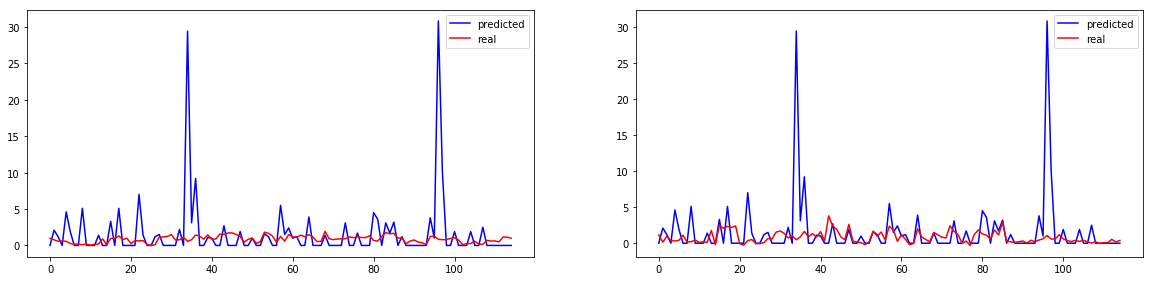

In [33]:
plt.figure()

# PLOT default MODEL PREDICTION  
plt.subplot(2, 2, 1)
plt.plot(y_test,'b', label="predicted")
plt.plot(default_pred,'r', label="real")
plt.legend()


# PLOT refined MODEL PREDICTION  
plt.subplot(2, 2, 2)
plt.plot(y_test,'b', label="predicted")
plt.plot(final_pred,'r', label="real")
plt.legend()



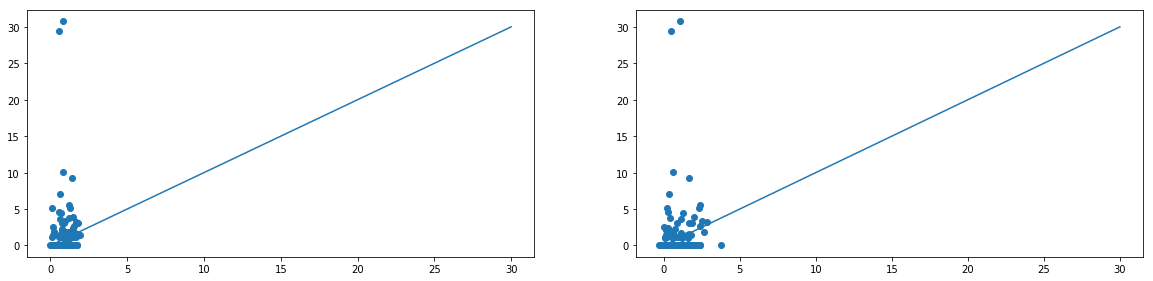

In [34]:
# PLOT MODEL PREDICTION (TEST DATA) AGAINST REAL DATA
plt.subplot(2, 2, 3)
plt.scatter(default_pred, y_test)
#plt.hold(True) 
a=np.arange(max(y_test))
plt.plot(a)

  
# PLOT MODEL PREDICTION (TEST DATA) AGAINST REAL DATA
plt.subplot(2, 2, 4)
plt.scatter(final_pred, y_test)
#plt.hold(True) 
a=np.arange(max(y_test))
plt.plot(a)

In [35]:
print(r2_score(default_pred, y_test))
print(r2_score(final_pred, y_test))

-83.7078902684603
-27.65655624492843


# Interpret the Model


* Locally Interpretable Model-agnostic Explainer (LIME)
* Examining a single decision tree in the ensemble.

In [38]:
lin_clf = SVR(kernel='linear')
lin_clf.fit(x_train, y_train)
scores = np.dot(x_train, lin_clf.coef_.T)

In [39]:
# b0 = y_train==0 # boolean or "mask" index arrays
# b1 = y_train==1
# malignant_scores = scores[b0]
# benign_scores = scores[b1]       

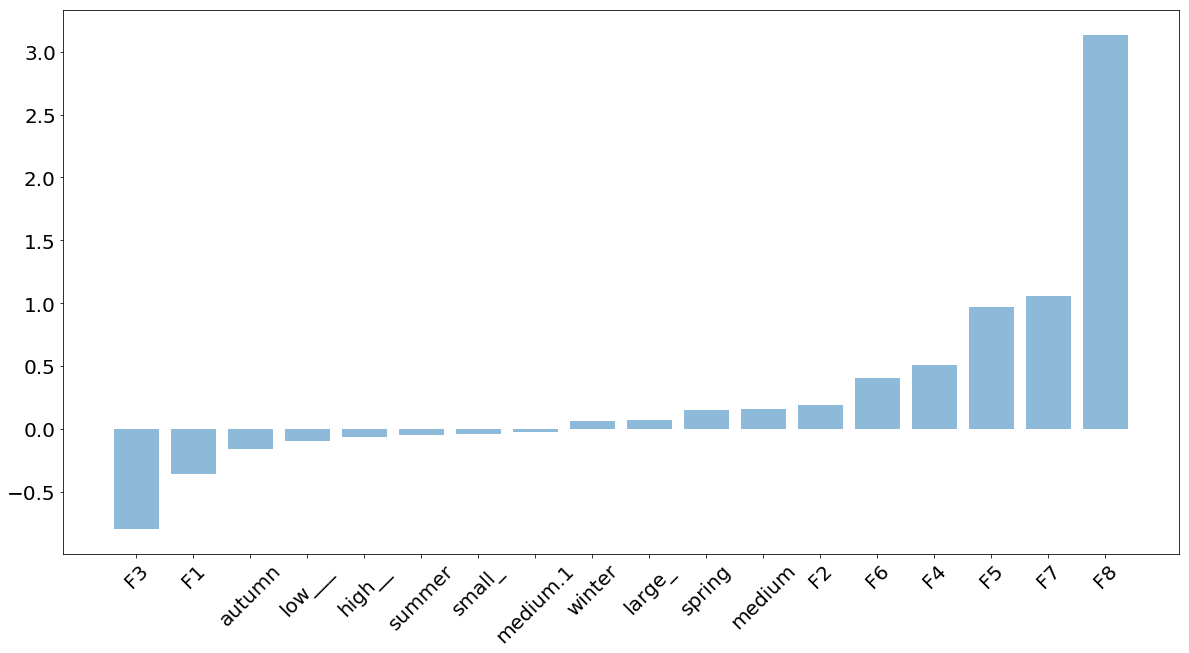

In [40]:
# https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn
    
def f_importances(coef, names):
    imp = coef
    imp, names = zip(*sorted(zip(imp,names)))
    y_pos = range(len(names))
    plt.bar(y_pos, imp, align='center', alpha=0.5)
    plt.xticks(y_pos, names, rotation=45)
    plt.tick_params(labelsize = 20)
    return imp, names


features_names = list(x_train_.columns.values)

svr = SVR(kernel='linear')
svr.fit(x_train, y_train)
imp_features, imp_names = f_importances(svr.coef_.tolist()[0], features_names)


## Use Feature Importances for Feature Selection

In [41]:
# Extract the names of the most important features
most_important_features = imp_names[:3] + imp_names[-3:]

# Find the index that corresponds to each feature name
indices = [list(x_train_.columns).index(i) for i in most_important_features]

# Keep only the most important features
x_train_reduced = x_train[:, indices]
x_test_reduced = x_test[:, indices]

print('Most important training features shape: ', x_reduced.shape)
print('Most important testing  features shape: ', x_test_reduced.shape)

NameError: name 'x_reduced' is not defined

### Re-run the training and testing code from before, replacing x_train and x_test with x_train_reduced and x_test_reduced

Linear regression results significantly improve



Algae 1
-5.413995621369821
Linear Regression Performance : 
train set : MAE = 3.055, NMSE = 0.497 
test set : MAE = 2.81,  NMSE = 0.609 
baseline : MAE = 1.793, NMSE = 0.609

-87.8406191934236
SVR Performance : 
train set : MAE = 2.509, NMSE = 0.473 
test set : MAE = 1.623,  NMSE = 0.609 
baseline : MAE = 1.793, NMSE = 0.609

-395.2792976397491
SVR, optimised Performance : 
train set : MAE = 2.586, NMSE = 0.473 
test set : MAE = 1.696,  NMSE = 0.609 
baseline : MAE = 1.793, NMSE = 0.609


Algae 2
-5.413995621369821
Linear Regression Performance : 
train set : MAE = 3.055, NMSE = 0.497 
test set : MAE = 2.81,  NMSE = 0.609 
baseline : MAE = 1.793, NMSE = 0.609

-87.8406191934236
SVR Performance : 
train set : MAE = 2.509, NMSE = 0.473 
test set : MAE = 1.623,  NMSE = 0.609 
baseline : MAE = 1.793, NMSE = 0.609

-395.2792976397491
SVR, optimised Performance : 
train set : MAE = 2.586, NMSE = 0.473 
test set : MAE = 1.696,  NMSE = 0.609 
baseline : MAE = 1.793, NMSE = 0.609


Algae 3
-5.4

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


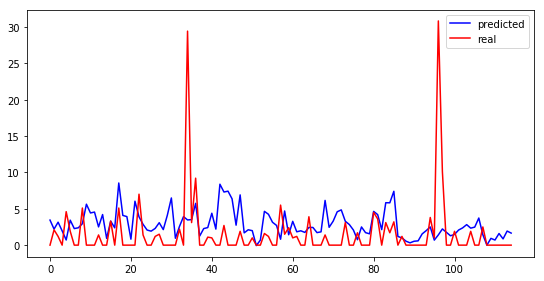

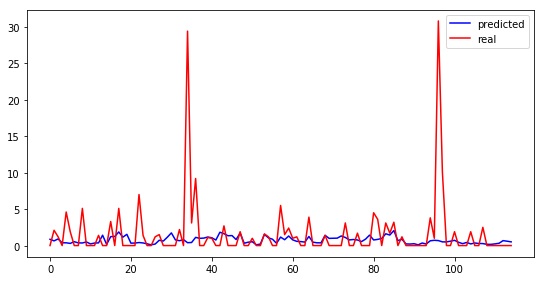

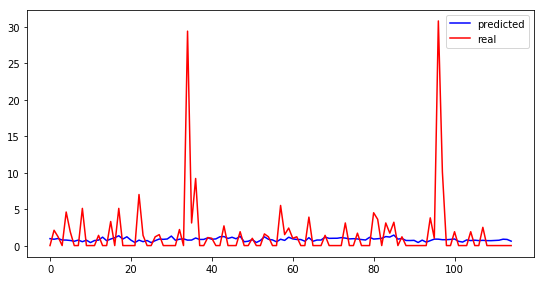

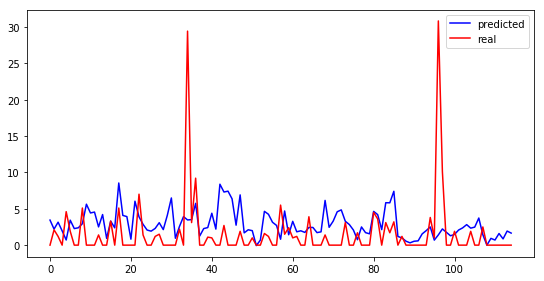

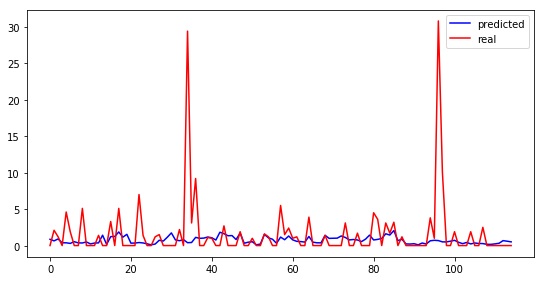

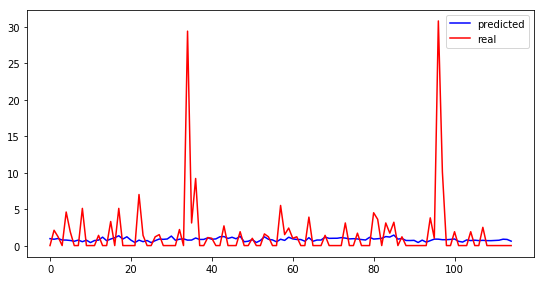

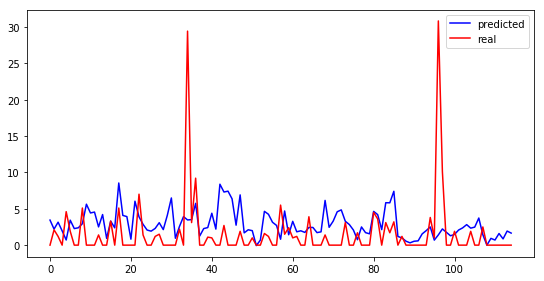

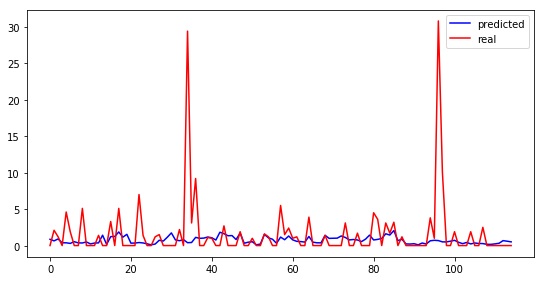

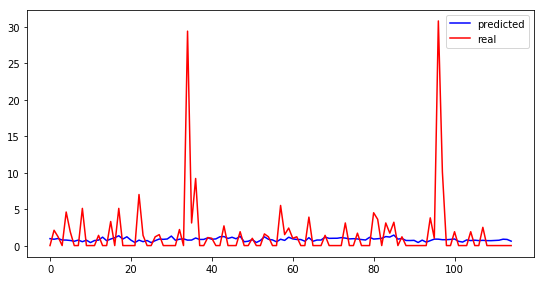

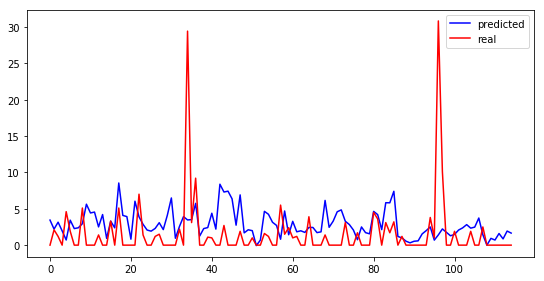

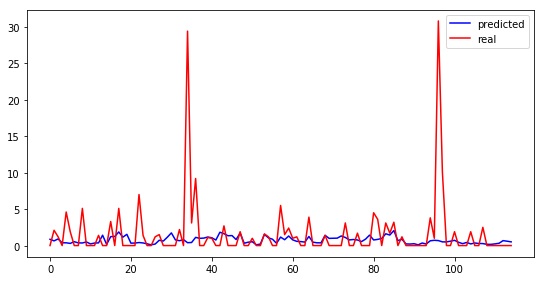

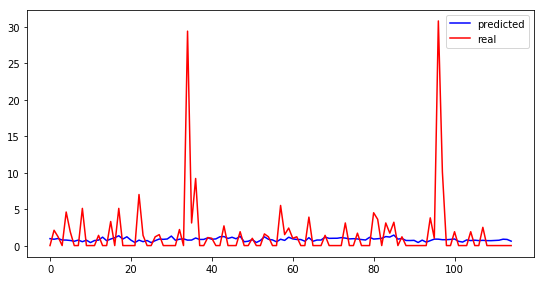

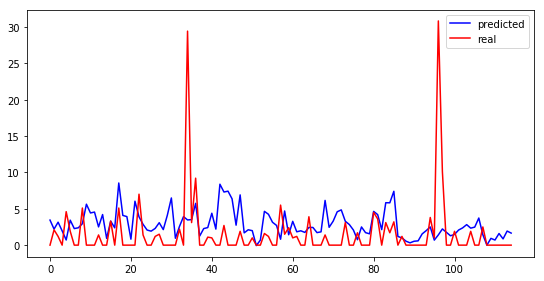

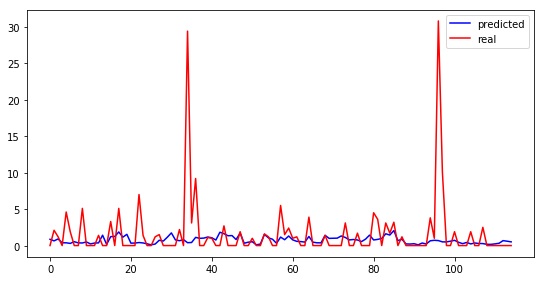

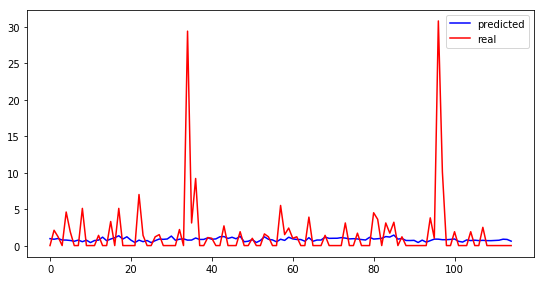

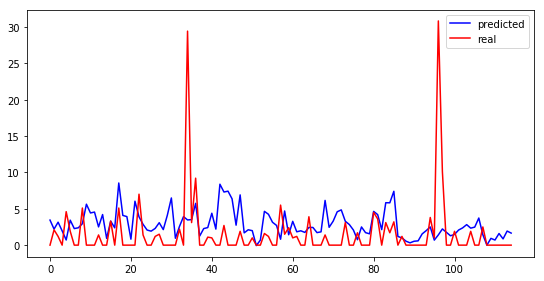

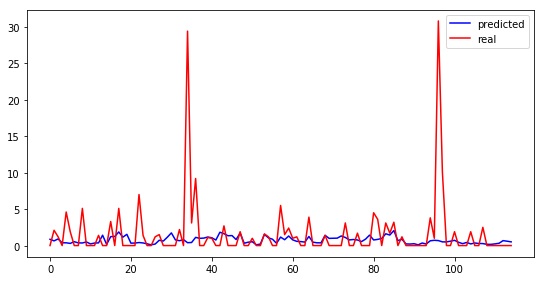

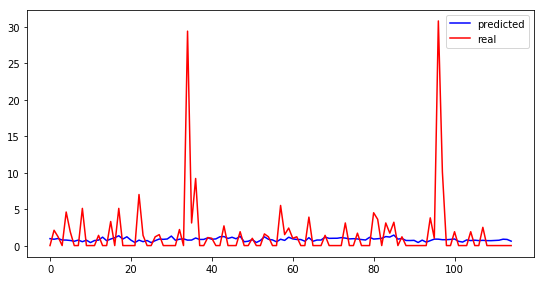

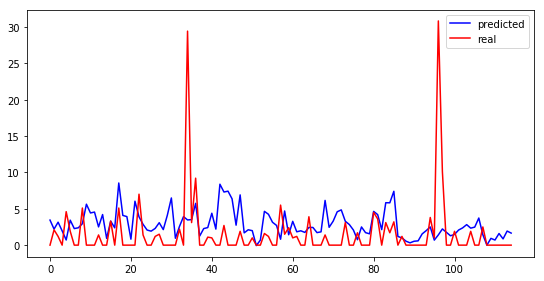

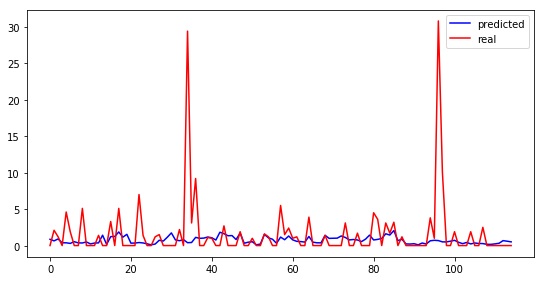

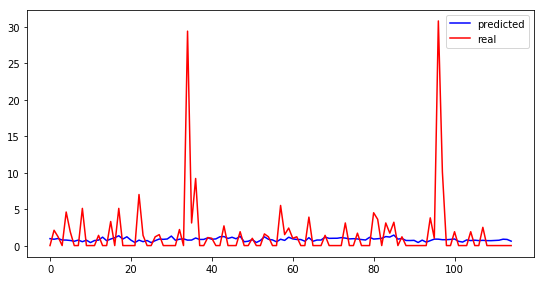

In [42]:

def fit_and_evaluate_v2(model, X_train, Y_train, X_test, Y_test):
    
    # Train the model
    model.fit(X_train, Y_train)
    
    # Make predictions and evalute
    # check the model correctly predicts the training data
    y_pred_train = model.predict(X_train)
    y_mae_train = np.round(mae(Y_train, y_pred_train), decimals=3)
    y_nmse_train = np.round(
        nmse(Y_train.reshape(-1, 1),
             y_pred_train.reshape(-1, 1)), 
        decimals=3) 


    # predict the real data
    y_pred_test = model.predict(X_test)   
    y_mae_test = np.round(mae(Y_test, y_pred_test), decimals=3)
    y_nmse_test = np.round(
        nmse(Y_test.reshape(-1, 1),
             y_pred_test.reshape(-1, 1)), 
        decimals=3) 
    print(r2_score(y_pred_test, Y_test))
    
    
    # PLOT refined MODEL PREDICTION  
    plt.figure()
    plt.subplot(2, 2, 2)
    plt.plot(y_pred_test,'b', label="predicted")
    plt.plot(Y_test,'r', label="real")
    plt.legend()

      
    # baseline performance
    baseline_guess = np.median(Y_train)
    y_mae_baseline = np.round(mae(Y_test, baseline_guess), decimals=3)
    y_nmse_baseline = np.round(
        nmse(Y_test.reshape(-1, 1),
             np.full_like(Y_test.reshape(-1, 1),baseline_guess)),
        decimals=3) 
    

    # Return the performance metric
    return y_pred_train, y_mae_train, y_nmse_train, y_pred_test, y_mae_test, y_nmse_test, y_mae_baseline, y_nmse_baseline


# Defining the columns in a list in order to use it in the for loop
algae_type=['Algae 1','Algae 2','Algae 3','Algae 4','Algae 5','Algae 6','Algae 7'] 

# this counter is used to call each algae type (for the plots and other printing porpuses)
counter=0; 
plt.rcParams['figure.figsize'] = [20, 10]

# y is the algae concentration
# x is the features 
from sklearn.preprocessing import normalize

# this for loop will run for each algae type once 
for A in algae_type: 
    counter=counter+1
    
#     # reading the training dataset (we generated this before) 
#     x_train_ = pd.read_csv('data/polished_train_data.csv').drop(columns=algae_type, axis=1) 
#     y_train_ = pd.read_csv('data/polished_train_data.csv', usecols=[A])
#     # dataframe --> array
#     x_train = x_train_.values
#     y_train = y_train_.values.ravel() # Convert y to one-dimensional array (vector)
#     # y_train = np.array(y_train_).reshape((-1, ))
    
#     #reading the test data set (we generated this before)
#     x_test_ = pd.read_csv('data/polished_test_data.csv').drop(columns=algae_type, axis=1) 
#     y_test_ = pd.read_csv('data/polished_test_data.csv', usecols=[A])
#     # dataframe --> array
#     x_test = x_test_.values
#     y_test = y_test_.values.ravel() # Convert y to one-dimensional array (vector)
    # y_test = np.array(y_test_).reshape((-1, ))
    
    
    # Scale values
    # Create the scaler object with a range of 0-1
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Fit on the training data
    scaler.fit(x_train)
    # Transform both the training and testing data
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)    
    
#     print(x_train.shape)
#     print(x_test.shape)
#     print(y_train.shape)
#     print(y_test.shape)
#     print()
    print(f"{A}") 
    
    # LinearRegression
    mod = 'Linear Regression'
    pred_train, mae_train, nmse_train, pred_test, mae_test, nmse_test, mae_baseline, nmse_baseline = fit_and_evaluate_v2(LinearRegression(), x_train_reduced, y_train, x_test_reduced, y_test)
    print(f"{ mod } Performance : \n" +
          f"train set : MAE = {mae_train}, NMSE = {nmse_train} \n" +
          f"test set : MAE = { mae_test},  NMSE = {nmse_test} \n" +
          f"baseline : MAE = { mae_baseline}, NMSE = { nmse_baseline}")
    print()
    
    # SVR
    mod = 'SVR'
    pred_train, mae_train, nmse_train, pred_test, mae_test, nmse_test, mae_baseline, nmse_baseline = fit_and_evaluate_v2(SVR(), x_train_reduced, y_train, x_test_reduced, y_test)
    print(f"{ mod } Performance : \n" +
          f"train set : MAE = {mae_train}, NMSE = {nmse_train} \n" +
          f"test set : MAE = { mae_test},  NMSE = {nmse_test} \n" +
          f"baseline : MAE = { mae_baseline}, NMSE = { nmse_baseline}")
    print()
    
    # SVR, optimised
    mod = 'SVR, optimised'
    pred_train, mae_train, nmse_train, pred_test, mae_test, nmse_test, mae_baseline, nmse_baseline = fit_and_evaluate_v2(SVR(kernel='rbf', C=500, gamma=.0001), x_train_reduced, y_train, x_test_reduced, y_test )
    print(f"{ mod } Performance : \n" +
          f"train set : MAE = {mae_train}, NMSE = {nmse_train} \n" +
          f"test set : MAE = { mae_test},  NMSE = {nmse_test} \n" +
          f"baseline : MAE = { mae_baseline}, NMSE = { nmse_baseline}")
    print()
    
    
    print()
    
    